### Downloading the Required Packgases for the Project

In [1]:
%pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report


%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


### EDA and Cleaning the Data

In [2]:
df = pd.read_csv('consumer_complaints.csv', parse_dates=['date_received', 'date_sent_to_company'], low_memory=False)
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511074
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511080
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,2013-09-18,Closed with explanation,Yes,No,510473
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,2013-08-30,Closed with explanation,Yes,Yes,510326
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,2013-08-30,Closed with explanation,Yes,Yes,511067


In [3]:
df.isna().sum()

date_received                        0
product                              0
sub_product                     158322
issue                                0
sub_issue                       343335
consumer_complaint_narrative    489151
company_public_response         470833
company                              0
state                             4887
zipcode                           4505
tags                            477998
consumer_consent_provided       432499
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed?                   0
complaint_id                         0
dtype: int64

To obtain high accuary and effecincy in while visualzing dataset it is important to have a clean dataset. Thus doing things like checking the number of empty rows is in an important part of that process



In [4]:
disputed = df.loc[df["consumer_disputed?"].isin(["Yes"])]
print("Total number of disputed customers: ", disputed.shape[0])
not_disputed = df.loc[df["consumer_disputed?"].isin(["No"])]
print("Total number of undisputed customers: ", not_disputed.shape[0])

Total number of disputed customers:  112134
Total number of undisputed customers:  443823


Due to the fact that there are may NAN values in the data, in order to clean the data and make it more suitable for analysis and visualization by redcuing the inaacuracies, I will remove all collums that contain  >= 10% NaNs. 

In [5]:
thresh = 0.10
col_nans = df.isna().mean(axis=0)
col_w_thresh = col_nans[col_nans >= thresh]
col_w_thresh

sub_product                     0.284774
sub_issue                       0.617557
consumer_complaint_narrative    0.879836
company_public_response         0.846887
tags                            0.859775
consumer_consent_provided       0.777936
dtype: float64

In [6]:
drops_l = list(col_w_thresh.index) + ['complaint_id']
df = df.drop(drops_l, axis=1)

#Tokenizing Yes and No to 1 and 0 respectively
df = df.replace(['Yes', 'No'], [1, 0])

#Also tokenizing company response for easier NLP classification
df.loc[df['company_response_to_consumer'].str.contains("Closed"), 'company_response_to_consumer'] = 1
df.loc[df['company_response_to_consumer'] != 1, 'company_response_to_consumer'] = 0
df.head()

,date_received,product,issue,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?
0,2013-08-30,Mortgage,"Loan modification,collection,foreclosure",U.S. Bancorp,CA,95993,Referral,2013-09-03,1,1,1
1,2013-08-30,Mortgage,"Loan servicing, payments, escrow account",Wells Fargo & Company,CA,91104,Referral,2013-09-03,1,1,1
2,2013-08-30,Credit reporting,Incorrect information on credit report,Wells Fargo & Company,NY,11764,Postal mail,2013-09-18,1,1,0
3,2013-08-30,Student loan,Repaying your loan,"Navient Solutions, Inc.",MD,21402,Email,2013-08-30,1,1,1
4,2013-08-30,Debt collection,False statements or representation,Resurgent Capital Services L.P.,GA,30106,Web,2013-08-30,1,1,1


### Analysis and Visualization of the Data

In [7]:
disputes = get_count('state')
st_c = disputes['consumer_disputed?']
m_st = disputes['state'][pd.Series.argmax(st_c)]
m_c = disputes['consumer_disputed?'][pd.Series.argmax(st_c)]
print("State is", m_st, "with max disputes:", m_c)

NameError: name 'get_count' is not defined

#### Number of disputed issues per state

In [8]:
issue_by_state = df.groupby("state")["issue"].agg('count').reset_index()
issue_total_state = issue_by_state.sort_values(by=['issue'], ascending=False)
issue_total_state.nlargest(5, 'issue')

,state,issue
8,CA,81700
13,FL,53673
53,TX,41352
42,NY,38266
15,GA,24548


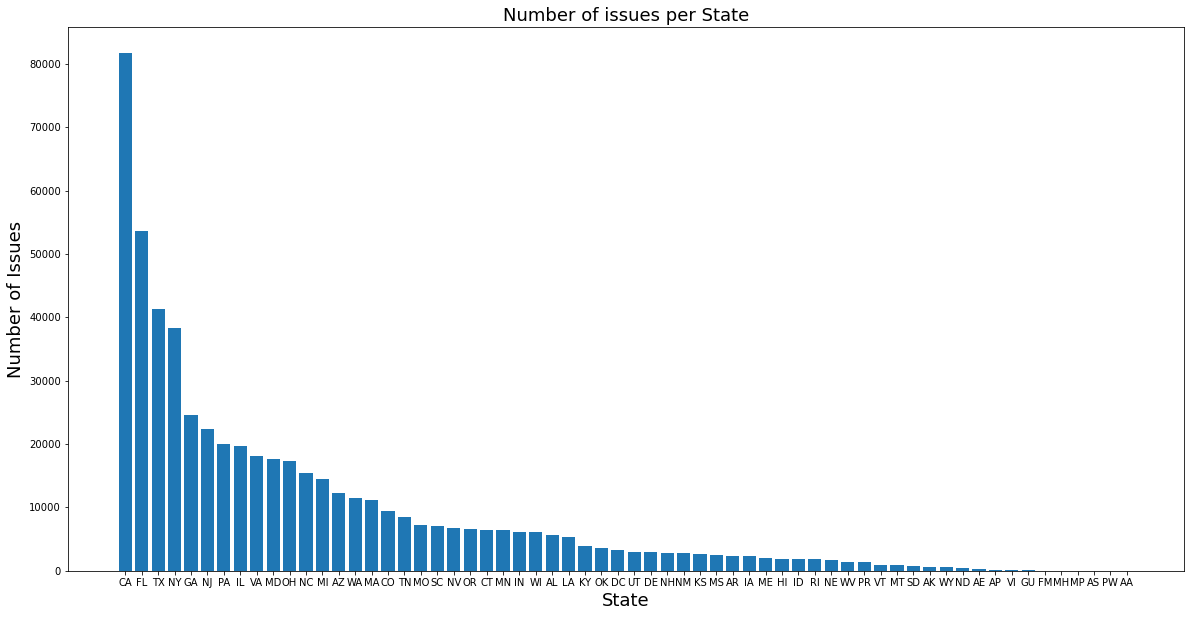

In [9]:
x = issue_total_state['state']
y = issue_total_state['issue']
plt.bar(x, y)
plt.xlabel("State", fontsize=18)
plt.ylabel("Number of Issues", fontsize=18)
plt.title("Number of issues per State", fontsize=18)
plt.gcf().set_size_inches(20, 10)

#### Number of  issues per product

In [10]:
issue_by_product = df.groupby("product")["issue"].agg('count').reset_index()
issue_total_product = issue_by_product.sort_values(by=['issue'], ascending=False)
issue_total_product.nlargest(5, 'issue')

,product,issue
6,Mortgage,186475
4,Debt collection,101052
3,Credit reporting,91854
2,Credit card,66468
0,Bank account or service,62563


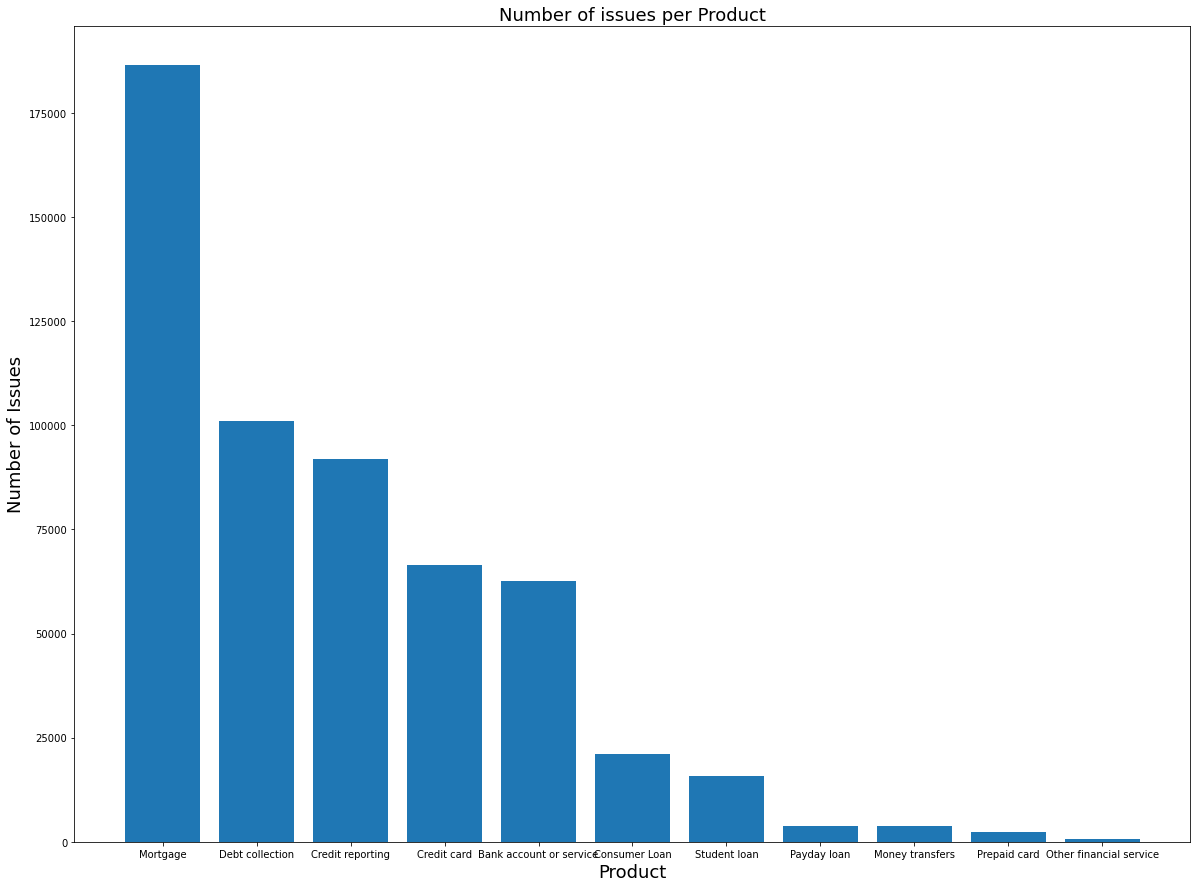

In [11]:
x = issue_total_product['product']
y = issue_total_product['issue']
plt.bar(x, y)
plt.xlabel("Product", fontsize=18)
plt.ylabel("Number of Issues", fontsize=18)
plt.title("Number of issues per Product", fontsize=18)
plt.gcf().set_size_inches(20, 15)

In [12]:
state_issue_count = df[['state', 'product', 'issue']].groupby(['state', 'product', 'issue']).size().reset_index()
state_issue_count.columns = ['state', 'product', 'issue', 'count']

In [13]:
state_issue_count.sort_values(by = 'count', ascending = False).head()


,state,product,issue,count
501,CA,Mortgage,"Loan modification,collection,foreclosure",19433
942,FL,Mortgage,"Loan modification,collection,foreclosure",11337
502,CA,Mortgage,"Loan servicing, payments, escrow account",8957
4028,TX,Credit reporting,Incorrect information on credit report,8712
485,CA,Credit reporting,Incorrect information on credit report,8585


### Number of issues submitted per medium of contact

In [38]:
#df_dist = df[df['consumer_disputed?'] == "Yes"]
medium_submited = df['submitted_via'].value_counts().reset_index()
medium_submited = medium_submited.rename(columns={'index': 'medium'})
medium_submited

,medium,submitted_via
0,Web,361338
1,Referral,109379
2,Phone,40026
3,Postal mail,36752
4,Fax,8118
5,Email,344


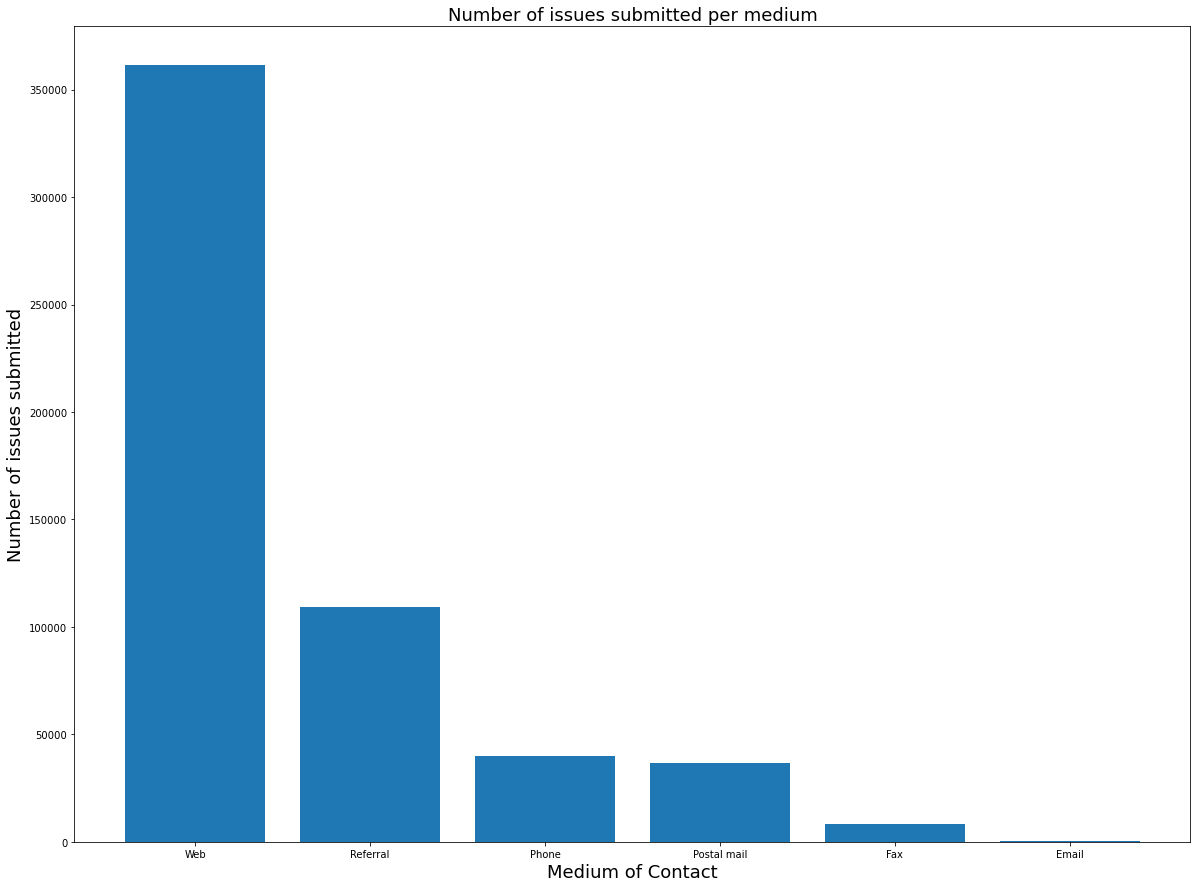

In [39]:
plt.bar(medium_submited['medium'], medium_submited['submitted_via'])
plt.xlabel("Medium of Contact", fontsize=18)
plt.ylabel("Number of issues submitted", fontsize=18)
plt.title("Number of issues submitted per medium", fontsize=18)
plt.gcf().set_size_inches(20, 15)

### Number of timely responses submitted per medium of contact

In [40]:
#df_time = df[df['timely_response'] == "Yes"]

medium_timely_submited = df['submitted_via'].value_counts().reset_index()
medium_timely_submited = medium_timely_submited.rename(columns={'index': 'medium'})
medium_timely_submited

,medium,submitted_via
0,Web,361338
1,Referral,109379
2,Phone,40026
3,Postal mail,36752
4,Fax,8118
5,Email,344


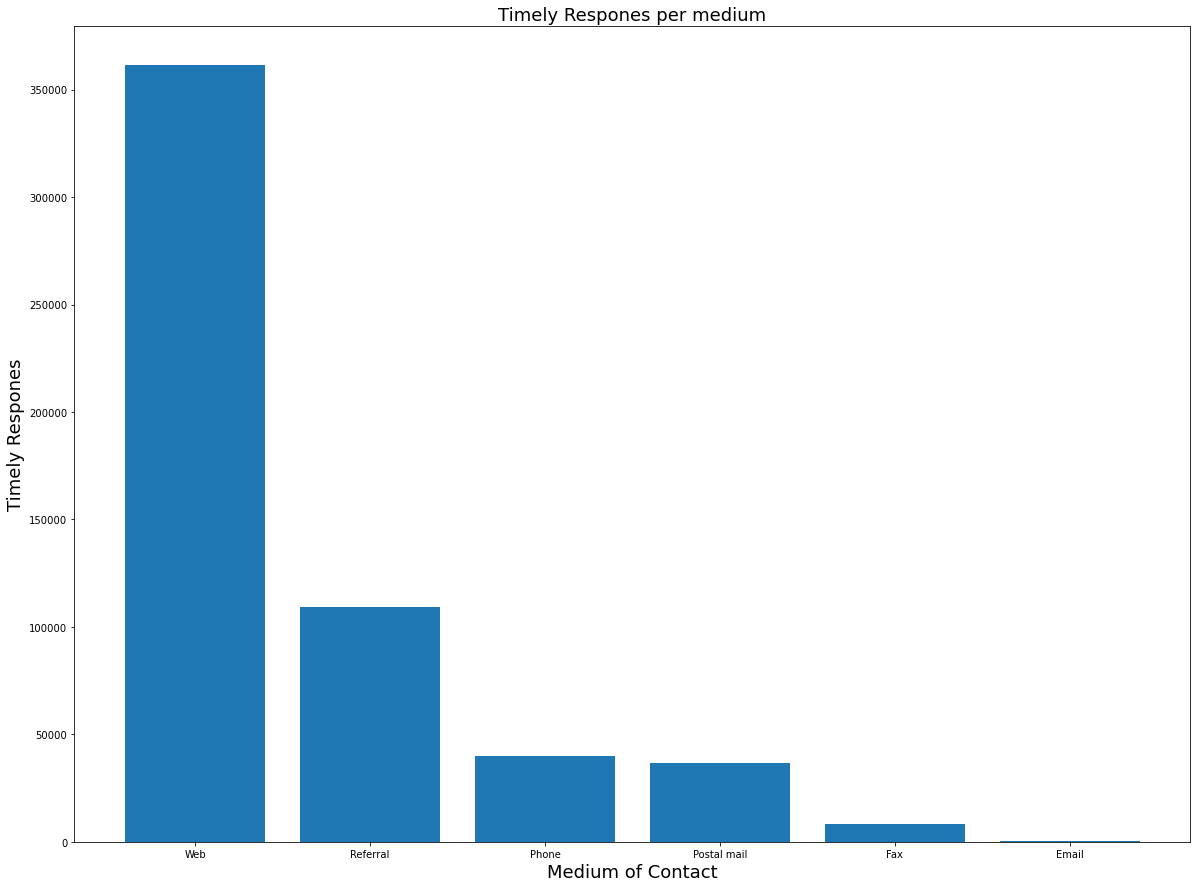

In [42]:
plt.bar(medium_timely_submited['medium'], medium_timely_submited['submitted_via'])
plt.xlabel("Medium of Contact", fontsize=18)
plt.ylabel("Timely Respones", fontsize=18)
plt.title("Timely Respones per medium", fontsize=18)
plt.gcf().set_size_inches(20, 15)

### ML Model - Analysis

In [17]:
date_cols = ['date_received', 'date_sent_to_company']
for date_col in date_cols:
    df[date_col] = df[date_col].apply(pd.Timestamp.toordinal)

analysis_cols = ['product', 'issue', 'state', 'submitted_via']
encoded = df
for c in analysis_cols:
    c_encoded = pd.get_dummies(encoded[c], prefix=c)
    encoded = pd.concat((encoded, c_encoded), axis=1).drop(c, axis=1)
encoded.head() 

,date_received,company,zipcode,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,product_Bank account or service,product_Consumer Loan,product_Credit card,...,state_WA,state_WI,state_WV,state_WY,submitted_via_Email,submitted_via_Fax,submitted_via_Phone,submitted_via_Postal mail,submitted_via_Referral,submitted_via_Web
0,735110,U.S. Bancorp,95993,735114,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,735110,Wells Fargo & Company,91104,735114,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,735110,Wells Fargo & Company,11764,735129,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,735110,"Navient Solutions, Inc.",21402,735110,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,735110,Resurgent Capital Services L.P.,30106,735110,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Since the key data is categorical in nature we can use one-hot encoding for it as there is no ordinal relationship in any of the data that is being used and we firstly use  Logistic Regression to classify one-hot-encoded features:





In [18]:
X = encoded.drop(['company', 'zipcode', 'consumer_disputed?'], axis=1)
y = encoded['consumer_disputed?']
X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.2, random_state=0)

In [27]:
classifier1 = LogisticRegression()
classifier1.fit(X_tr, y_tr)
y_pred = classifier1.predict(X_t)

print("Classifier accuracy is", accuracy_score(y_t, y_pred))

Classifier accuracy is 0.7980160443197353


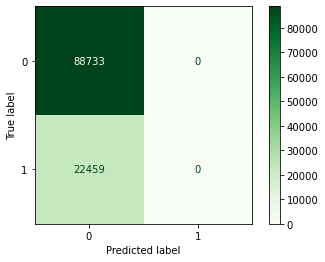

In [28]:
plot_confusion_matrix(classifier1, X_t, y_t, cmap=plt.cm.Greens)


As we can see the classifier needs a great deal of work to accurately predict a disputed complaint as the above confusion matrix shows that a true disputed complaint is not recognized by the classifier, thus we use Randon Forest to make a better prediction.Random forests is great with high dimensional data since we are working with subsets of data. It is faster to train than decision trees because we are working only on a subset of features in this model, so we can easily work with hundreds of features

In [29]:
classifier2 = DecisionTreeClassifier(random_state=42)
classifier2.fit(X_tr, y_tr)
y_pred = classifier2.predict(X_t)

print("Classifier accuracy is", accuracy_score(y_t, y_pred))

Classifier accuracy is 0.7119846751564861


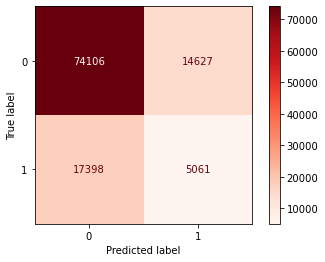

In [30]:
plot_confusion_matrix(classifier2, X_t, y_t, cmap=plt.cm.Reds)


In [31]:
print(classification_report(y_t, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.84      0.82     88733
           1       0.26      0.23      0.24     22459

    accuracy                           0.71    111192
   macro avg       0.53      0.53      0.53    111192
weighted avg       0.70      0.71      0.70    111192



The decision tree model has a lower accuracy but because it deals with the categorical data better it manages to correctly predict some of the disputed issues.



Further research and exploration regarding the finding correlations between different variable columns in the data set as well as applying more machine learning models would enable us to further visualize the data and finding more insights into the dataset. 

Regarding the Ml models The decision tree model has a lower accuracy but because it deals with the categorical data better it manages to correctly predict some of the disputed issues.
Since both models are very quick and dirty, detailed parsing of the data using the nltk library would be the ideal direction that should be taken in getting a higher recall and higher number of true positive recognition in the future.

However, it must be noted that the visualizations and insights provided by the dataset do inform of key areas for our company to be wary and cautious of, and with constant improvement of data preparation and more robust training models or models that offer different sets of insights there lies a higher scope of predicting disputed issues and even company responses.
